In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [8]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
GALARY = '/tigress/jiaxuanl/public_html/galary'

In [5]:
from paper_figure import quenched_frac

In [6]:
### UDG ###
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)


fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 32.70887732960614


% of contaminants in the sample: 15.80 +- 2.60


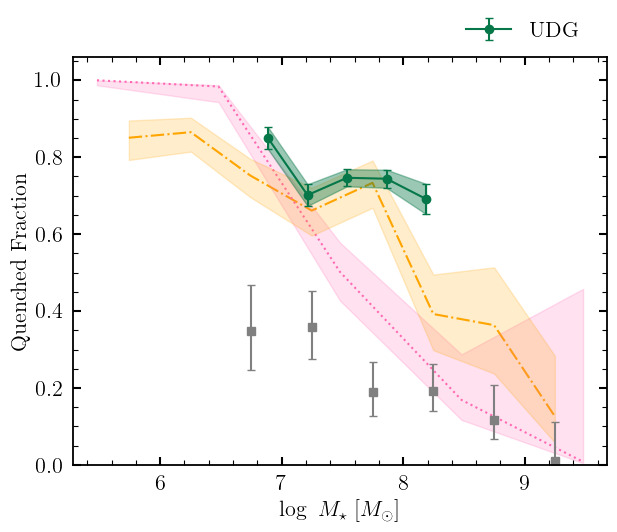

In [11]:
quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)

plt.legend(ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60


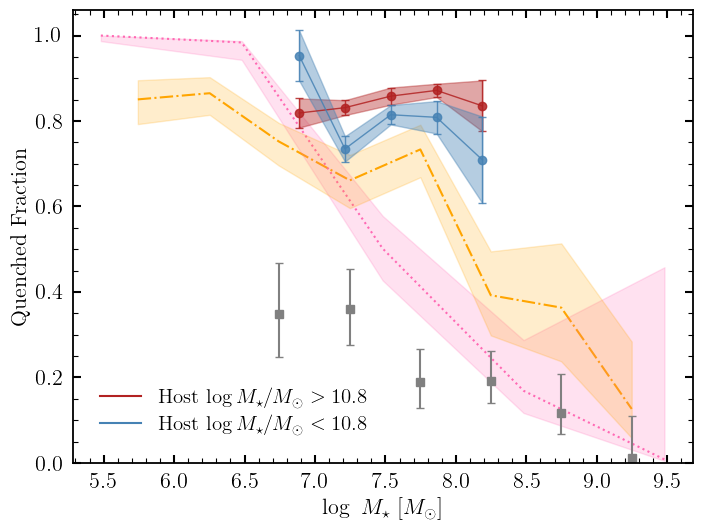

In [12]:
thresh = 10.8

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                        min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                        flag=(udg_cat['host_stellar_mass'] > thresh), 
                        linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_stellar_mass'] <= thresh), linecolor='steelblue', ax=ax, plot_ref=False)


# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))
# ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='firebrick', label=r'Host $\log M_\star / M_\odot > 10.8$')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Host $\log M_\star / M_\odot < 10.8$')

plt.legend(handles=[k_line, b_line], 
           fontsize=15, 
           loc='lower left',
#            bbox_to_anchor=(0., 1.0, 1.3, .0)
          )

In [13]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

In [15]:
handles

[<ErrorbarContainer object of 3 artists>]

% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60


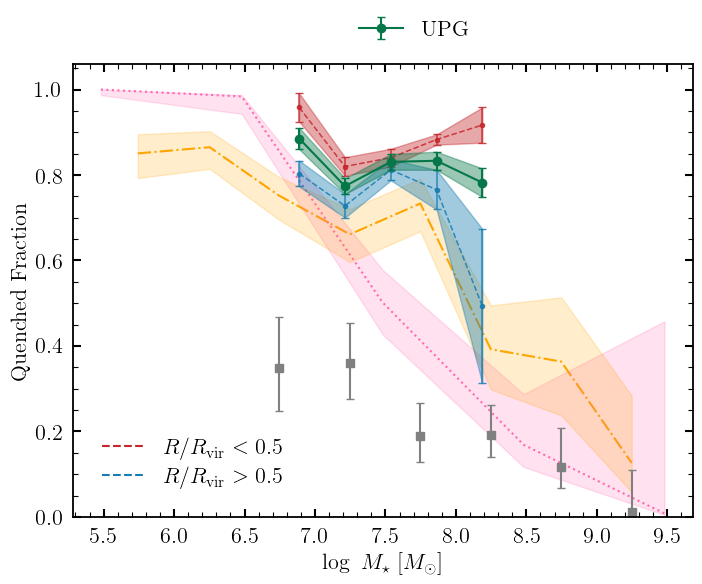

In [17]:
thresh = 0.5

fig, ax = plt.subplots(figsize=(8, 6))

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              name='UPG',
              flag=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5,
                        ax=ax, plot_ref=True)


fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio <= thresh), linecolor='#c3272b', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio > thresh), linecolor='#177cb0', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, loc='upper center', bbox_to_anchor=(0.3, 0.66, 0.5, 0.5))
ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{thresh}$')

plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
          )

In [124]:
import pickle
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in udg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


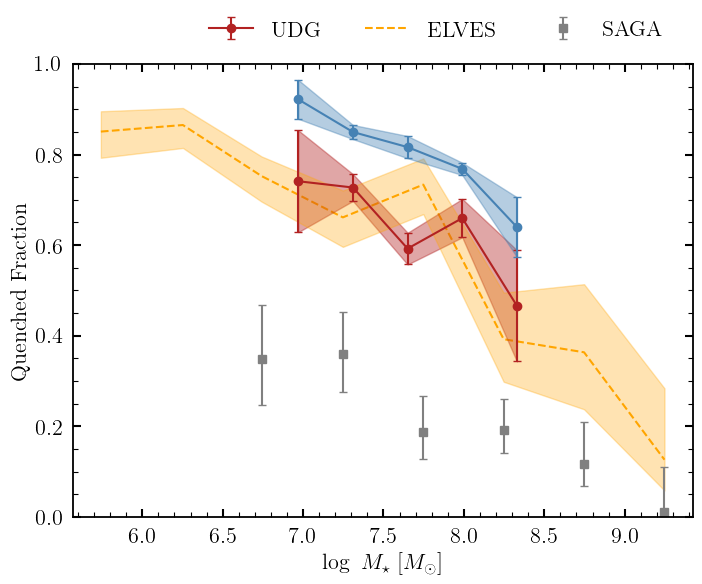

In [125]:
thresh = 1.2

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


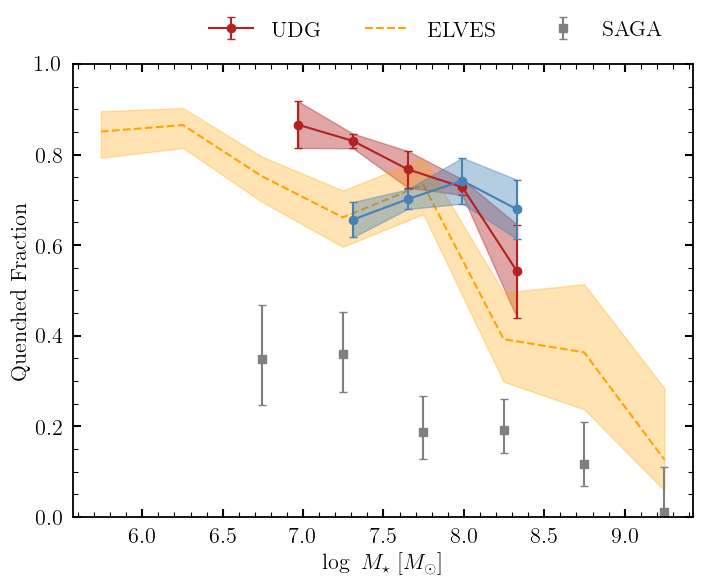

In [127]:
thresh = 0.035

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

---

### Big figure

In [18]:
import matplotlib.lines as mlines
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

#### Host color

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


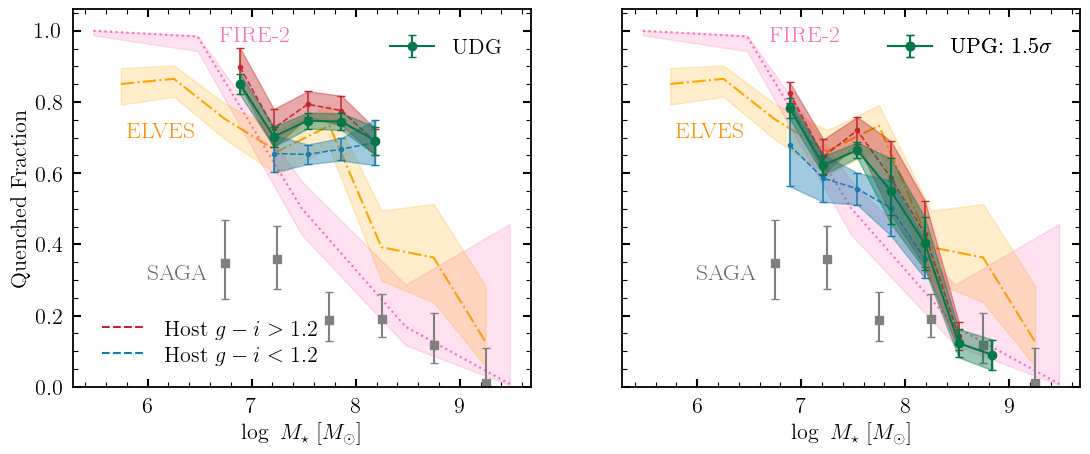

In [30]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]


_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax1.text(6.7, 0.97, 'FIRE-2', color='hotpink', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax2.text(6.7, 0.97, 'FIRE-2', color='hotpink', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_host_color.pdf', 
#             bbox_inches='tight', dpi=50)

#### Radial distance

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


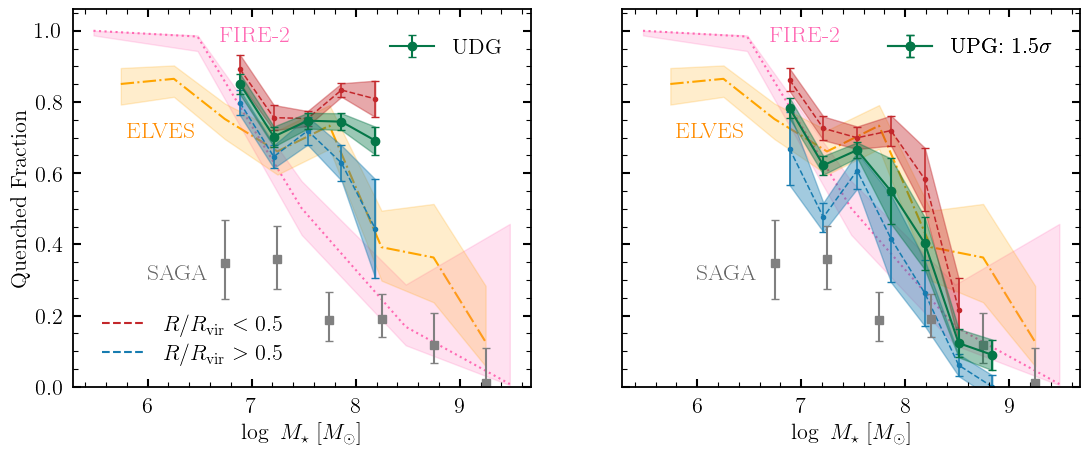

In [29]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax1.text(6.7, 0.97, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax2.text(6.7, 0.97, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')


# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_dist2host.pdf', 
#             bbox_inches='tight', dpi=50)

#### Host stellar mass

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


Text(0, 0.5, '')

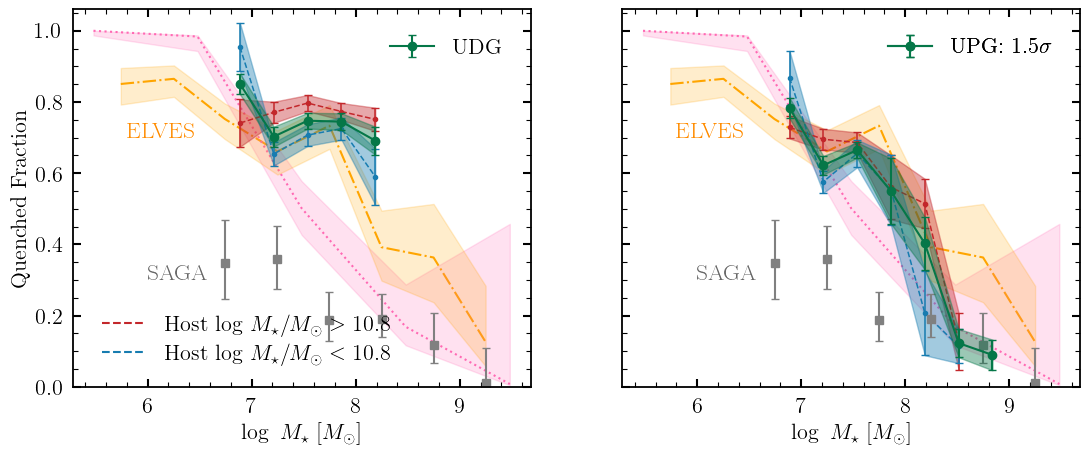

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg


flag_thresh = 10.8
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

flag_thresh = 10.8
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] <= flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')


Total angular area [deg2]: 17.019095304816766
Total angular area [deg2]: 32.632327280019645


(array([0.734234  , 1.50039121, 1.24500547, 1.14923582, 1.53231443,
        0.98961974, 0.70231078, 1.24500547, 0.98961974, 0.79808043]),
 array([0.0802539 , 0.17211655, 0.2639792 , 0.35584185, 0.4477045 ,
        0.53956715, 0.6314298 , 0.72329244, 0.81515509, 0.90701774,
        0.99888039]),
 [<matplotlib.patches.Polygon at 0x2ad0dc97a7a0>])

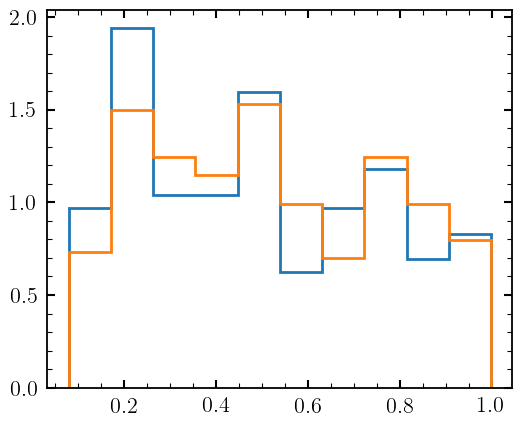

In [32]:
### UPG ###
name = 'upg'
thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data


plt.hist(dist_ratio, lw=2, histtype='step', density=True)


### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True)


In [46]:
name = 'upg'
thresh = 1.5
udg_cat15 = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')


thresh = 2
udg_cat20 = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

In [50]:
udg_cat_15_20 = udg_cat15[~np.in1d(udg_cat15['viz-id'], udg_cat20['viz-id'])]

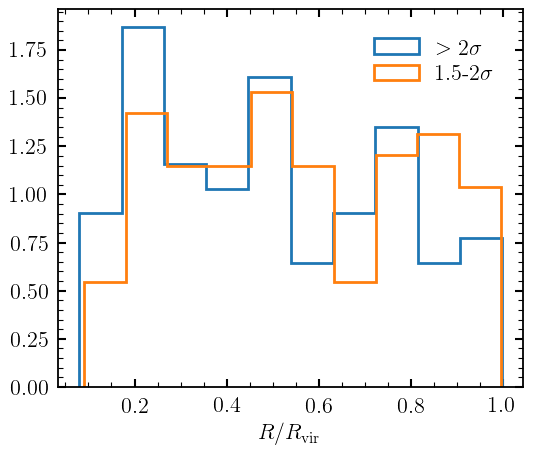

In [60]:
### UPG ###
udg_coord = SkyCoord(udg_cat20['ra'], udg_cat20['dec'], unit='deg')
host_coord = SkyCoord(udg_cat20['host_RA'], udg_cat20['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat20['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True, label='$>2\sigma$')

### UPG ###
udg_coord = SkyCoord(udg_cat_15_20['ra'], udg_cat_15_20['dec'], unit='deg')
host_coord = SkyCoord(udg_cat_15_20['host_RA'], udg_cat_15_20['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat_15_20['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True, label='1.5-2$\sigma$')

plt.xlabel(r'$R/R_{\rm vir}$')
plt.legend()